In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import xgboost as xgb
import lightgbm as lgbm
import catboost
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from IPython.display import display
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from verstack import LGBMTuner
from sklearn.preprocessing import StandardScaler
import category_encoders as ce

In [9]:
train_df = pd.read_csv("train.csv" , index_col = 0)
test_df = pd.read_csv("test.csv" , index_col=0)
display(train_df.head())
display(test_df.head())



,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
id,,,,,,,,,,,,,,,,,,,,,
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,80,1,10,2,3,10,0,7,8,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,80,1,4,3,3,4,2,0,3,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,80,2,4,3,3,3,2,1,2,0
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,...,80,0,15,1,1,6,0,0,2,0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,...,80,0,31,0,3,31,14,4,10,1


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
id,,,,,,,,,,,,,,,,,,,,,
1677,19,Non-Travel,992,Research & Development,1,1,Medical,1,4,Male,...,4,80,0,1,2,2,1,0,0,0
1678,45,Travel_Rarely,1136,Sales,4,4,Marketing,1,3,Male,...,3,80,1,7,3,3,2,2,2,2
1679,37,Travel_Rarely,155,Research & Development,13,3,Life Sciences,1,4,Male,...,2,80,2,13,2,2,7,7,1,7
1680,32,Travel_Rarely,688,Research & Development,1,4,Life Sciences,1,3,Male,...,3,80,0,14,2,2,14,10,11,8
1681,29,Travel_Frequently,464,Research & Development,9,1,Life Sciences,1,3,Male,...,1,80,0,1,5,3,1,0,0,0


In [10]:
X=train_df.iloc[:,0:-1]
y=train_df.iloc[:,-1]

In [11]:
feats_to_drop = [col for col in X.columns if X[col].nunique()==1]
cat_features = [col for col in X.columns if X[col].nunique() <= 20 and X[col].nunique() > 1]

In [12]:
X.drop(columns=feats_to_drop, inplace=True)
X

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
id,,,,,,,,,,,,,,,,,,,,,
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,4,Male,42,...,3,2,1,10,2,3,10,0,7,8
1,35,Travel_Rarely,921,Sales,8,3,Other,1,Male,46,...,3,4,1,4,3,3,4,2,0,3
2,32,Travel_Rarely,718,Sales,26,3,Marketing,3,Male,80,...,3,4,2,4,3,3,3,2,1,2
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,3,Female,40,...,3,3,0,15,1,1,6,0,0,2
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,2,Female,37,...,3,3,0,31,0,3,31,14,4,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,30,Travel_Rarely,945,Sales,1,3,Life Sciences,4,Female,73,...,3,2,0,10,2,4,10,0,0,8
1673,32,Travel_Rarely,1303,Research & Development,2,3,Life Sciences,1,Male,48,...,3,4,1,10,3,4,4,2,1,3
1674,29,Travel_Frequently,1184,Human Resources,24,3,Human Resources,2,Male,36,...,3,3,0,1,2,3,1,0,0,0


In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif#ANOVA

In [16]:
ord_enc = OrdinalEncoder()

ord_enc.fit(X[cat_features])

X[cat_features] = ord_enc.transform(X[cat_features])
X.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
id,,,,,,,,,,,,,,,,,,,,,
0,36,1.0,599,1.0,24,2.0,3.0,3.0,1.0,42,...,0.0,1.0,1.0,10,2.0,2.0,10,0.0,7.0,8.0
1,35,2.0,921,2.0,8,2.0,4.0,0.0,1.0,46,...,0.0,3.0,1.0,4,3.0,2.0,4,2.0,0.0,3.0
2,32,2.0,718,2.0,26,2.0,2.0,2.0,1.0,80,...,0.0,3.0,2.0,4,3.0,2.0,3,2.0,1.0,2.0
3,38,2.0,1488,1.0,2,2.0,3.0,2.0,0.0,40,...,0.0,2.0,0.0,15,1.0,0.0,6,0.0,0.0,2.0
4,50,2.0,1017,1.0,5,3.0,3.0,1.0,0.0,37,...,0.0,2.0,0.0,31,0.0,2.0,31,14.0,4.0,10.0


In [17]:
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(X, y)

SelectKBest(k='all')

In [18]:
feature_contribution=(fs.scores_/sum(fs.scores_))*100

In [19]:
%matplotlib inline

Age : 9.06%
BusinessTravel : 0.00%
DailyRate : 0.17%
Department : 0.35%
DistanceFromHome : 0.21%
Education : 2.52%
EducationField : 0.01%
EnvironmentSatisfaction : 2.93%
Gender : 0.61%
HourlyRate : 0.47%
JobInvolvement : 6.79%
JobLevel : 6.54%
JobRole : 0.26%
JobSatisfaction : 1.27%
MaritalStatus : 10.68%
MonthlyIncome : 5.57%
MonthlyRate : 0.01%
NumCompaniesWorked : 0.47%
OverTime : 10.61%
PercentSalaryHike : 0.34%
PerformanceRating : 0.06%
RelationshipSatisfaction : 2.63%
StockOptionLevel : 13.30%
TotalWorkingYears : 6.68%
TrainingTimesLastYear : 0.12%
WorkLifeBalance : 0.70%
YearsAtCompany : 5.59%
YearsInCurrentRole : 6.17%
YearsSinceLastPromotion : 0.50%
YearsWithCurrManager : 5.37%


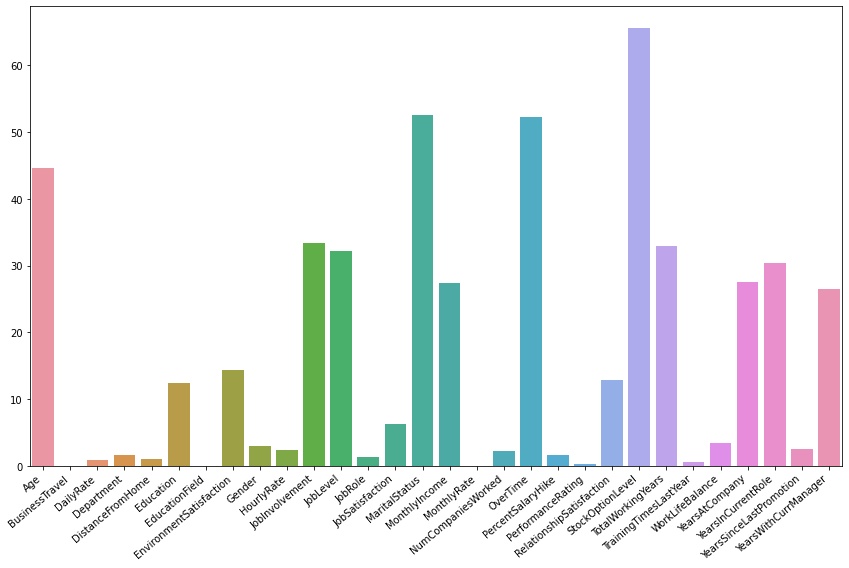

In [20]:
for i,j in enumerate(X.columns):
    print(f'{j} : {feature_contribution[i]:.2f}%')
plt.figure(figsize=(12,8))
ax=sns.barplot(x=X.columns,y=fs.scores_)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


In [21]:
sc = StandardScaler()
X = sc.fit_transform(X)
X

array([[-0.00434716, -1.15268092, -0.78461978, ..., -1.15687453,
         1.64918989,  1.06663669],
       [-0.12193094,  0.50801144,  0.07545836, ..., -0.59857854,
        -0.64980549, -0.33191666],
       [-0.47468226,  0.50801144, -0.46676482, ..., -0.59857854,
        -0.32137758, -0.61162733],
       ...,
       [-0.82743358, -1.15268092,  0.77794455, ..., -1.15687453,
        -0.64980549, -1.17104867],
       [-0.00434716,  0.50801144, -1.20664571, ..., -0.31943054,
        -0.64980549,  1.06663669],
       [-0.00434716,  0.50801144,  0.66308939, ..., -0.59857854,
         1.64918989, -0.33191666]])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [24]:
X_train1 = pd.DataFrame(X_train)
y_train1 = pd.Series(y_train)


Streaming output truncated to the last 5000 lines.
[61]	valid_0's binary_logloss: 0.30246
[62]	valid_0's binary_logloss: 0.302144
[63]	valid_0's binary_logloss: 0.301463
[64]	valid_0's binary_logloss: 0.301281
[65]	valid_0's binary_logloss: 0.300812
[66]	valid_0's binary_logloss: 0.300625
[67]	valid_0's binary_logloss: 0.300252
[68]	valid_0's binary_logloss: 0.299793
[69]	valid_0's binary_logloss: 0.299481
[70]	valid_0's binary_logloss: 0.299303
[71]	valid_0's binary_logloss: 0.298582
[72]	valid_0's binary_logloss: 0.298493
[73]	valid_0's binary_logloss: 0.298221
[74]	valid_0's binary_logloss: 0.297814
[75]	valid_0's binary_logloss: 0.297636
[76]	valid_0's binary_logloss: 0.297573
[77]	valid_0's binary_logloss: 0.296987
[78]	valid_0's binary_logloss: 0.296439
[79]	valid_0's binary_logloss: 0.295831
[80]	valid_0's binary_logloss: 0.295381
[81]	valid_0's binary_logloss: 0.295369
[82]	valid_0's binary_logloss: 0.29493
[83]	valid_0's binary_logloss: 0.294624
[84]	valid_0's binary_logloss: 

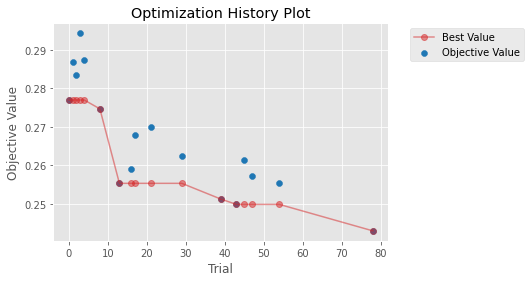

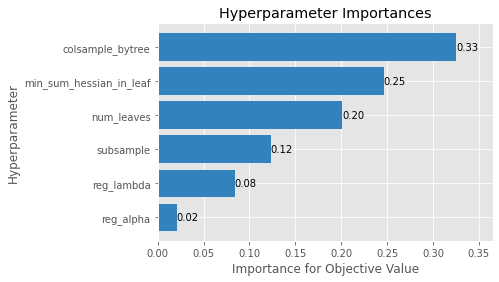

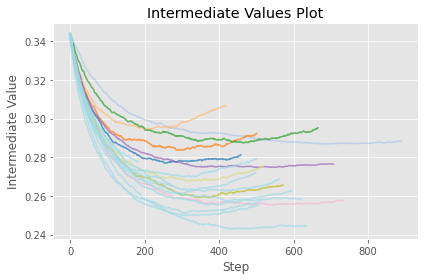

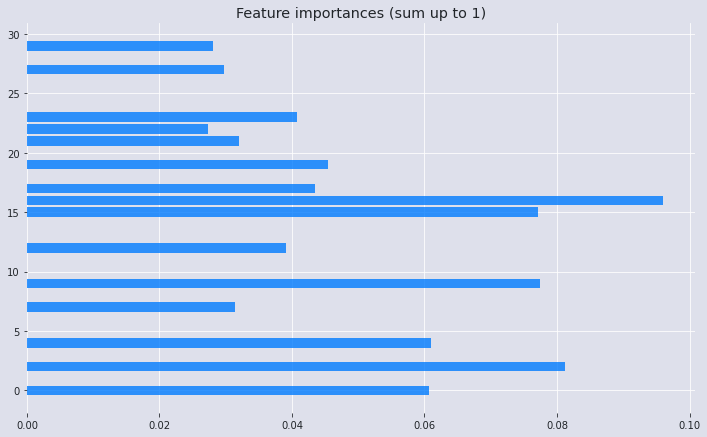


     . Optuna hyperparameters optimization finished
     .. Best trial number:78    |     log_loss:          0.24292696244568665
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  489   |     auc:           0.8259780534351144

Time elapsed for fit execution: 34.8537 seconds


In [25]:
# tune the hyperparameters and fit the optimized model
tuner = LGBMTuner(metric = 'auc',visualization = True) # <- the only required argument
tuner.fit(X_train1, y_train1)# check the optimization log in the console.pred = tuner.predict(test)

In [28]:
feats_to_drop = [col for col in test_df.columns if test_df[col].nunique()==1]
cat_features = [col for col in test_df.columns if test_df[col].nunique() <= 20 and test_df[col].nunique() > 1]

In [29]:
test_df.drop(columns=feats_to_drop, inplace=True)
test_df

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
id,,,,,,,,,,,,,,,,,,,,,
1677,19,Non-Travel,992,Research & Development,1,1,Medical,4,Male,43,...,3,4,0,1,2,2,1,0,0,0
1678,45,Travel_Rarely,1136,Sales,4,4,Marketing,3,Male,67,...,3,3,1,7,3,3,2,2,2,2
1679,37,Travel_Rarely,155,Research & Development,13,3,Life Sciences,4,Male,41,...,3,2,2,13,2,2,7,7,1,7
1680,32,Travel_Rarely,688,Research & Development,1,4,Life Sciences,3,Male,89,...,3,3,0,14,2,2,14,10,11,8
1681,29,Travel_Frequently,464,Research & Development,9,1,Life Sciences,3,Male,79,...,3,1,0,1,5,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,31,Travel_Rarely,755,Sales,1,1,Life Sciences,3,Male,81,...,3,3,1,1,1,3,1,0,0,0
2792,40,Travel_Rarely,654,Research & Development,26,5,Medical,3,Male,96,...,3,4,1,20,4,3,20,10,1,8
2793,42,Travel_Frequently,884,Research & Development,1,4,Medical,2,Female,65,...,3,1,1,10,2,2,5,3,0,2


In [30]:
ord_enc = OrdinalEncoder()

ord_enc.fit(test_df[cat_features])

test_df[cat_features] = ord_enc.transform(test_df[cat_features])
test_df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
id,,,,,,,,,,,,,,,,,,,,,
1677,19,0.0,992,1.0,1,0.0,3.0,4.0,1.0,43,...,0.0,3.0,0.0,1,2.0,1.0,1,0.0,0.0,0.0
1678,45,2.0,1136,2.0,4,3.0,2.0,3.0,1.0,67,...,0.0,2.0,1.0,7,3.0,2.0,2,2.0,2.0,2.0
1679,37,2.0,155,1.0,13,2.0,1.0,4.0,1.0,41,...,0.0,1.0,2.0,13,2.0,1.0,7,7.0,1.0,7.0
1680,32,2.0,688,1.0,1,3.0,1.0,3.0,1.0,89,...,0.0,2.0,0.0,14,2.0,1.0,14,10.0,11.0,8.0
1681,29,1.0,464,1.0,9,0.0,1.0,3.0,1.0,79,...,0.0,0.0,0.0,1,5.0,2.0,1,0.0,0.0,0.0


In [31]:
sc = StandardScaler()
test_df = sc.fit_transform(test_df)
test_df

array([[-1.95252911e+00, -2.46892975e+00,  2.96096988e-01, ...,
        -1.18477175e+00, -6.33852610e-01, -1.15578216e+00],
       [ 1.00801300e+00,  5.83813223e-01,  6.89256597e-01, ...,
        -6.18449841e-01, -2.34558195e-02, -6.19246072e-01],
       [ 9.70769633e-02,  5.83813223e-01, -1.98914324e+00, ...,
         7.97354930e-01, -3.28654215e-01,  7.22094142e-01],
       ...,
       [ 6.66411984e-01, -9.42558264e-01,  1.22728182e-03, ...,
        -3.35288887e-01, -6.33852610e-01, -6.19246072e-01],
       [-1.26932709e+00, -9.42558264e-01,  1.59843819e+00, ...,
        -6.18449841e-01, -3.28654215e-01, -3.50978029e-01],
       [ 6.66411984e-01,  5.83813223e-01,  9.56823553e-01, ...,
         7.97354930e-01,  5.86940971e-01,  1.25863023e+00]])

In [32]:
test1 = pd.DataFrame(test_df)

In [34]:


y_pred=tuner.predict_proba(test1)
y_pred



array([0.05699619, 0.00846864, 0.02803434, ..., 0.00928412, 0.0109943 ,
       0.00442696])

In [35]:
ss = pd.read_csv("sample_submission.csv", index_col=0)
ss['Attrition'] = y_pred
ss.to_csv("submission2.csv")
ss

,Attrition
id,
1677,0.056996
1678,0.008469
1679,0.028034
1680,0.012263
1681,0.354649
...,...
2791,0.038646
2792,0.004099
2793,0.009284
